2024-03-21 03:27:25.702105: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 03:27:25.707320: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-21 03:27:25.871785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 03:27:27.870179: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


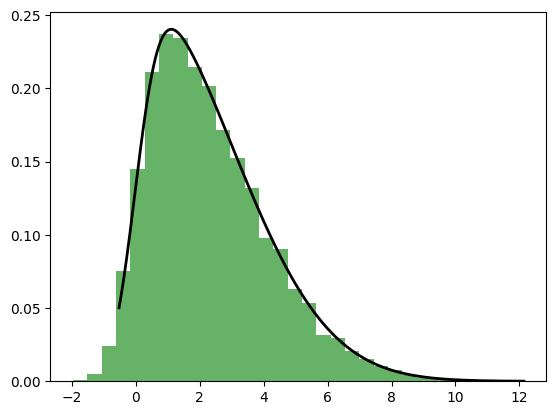

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skewnorm
import tensorflow as tf

# Define the number of samples, the location, the scale, and the skewness
num_samples = 10000
mu_data = 0.0  # location (mean) 
sd_data = 3.0  # scale (standard deviation) 
alpha_data = 5.0  # skewness (negative value means left skew, positive means right skew)

# Generate samples from the skew normal distribution
dist = skewnorm(alpha_data, mu_data, sd_data)
samples = dist.rvs(num_samples)
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
xmin = xmin + 1/7 * (xmax - xmin)
x = np.linspace(xmin, xmax, 1000)
p = skewnorm.pdf(x, alpha_data, mu_data, sd_data)
plt.plot(x, p, 'k', linewidth=2)
x_values = x 
y_values = p
plt.show()

In [2]:
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="he_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": tf.keras.activations.serialize(self.activation)}

In [ ]:
class OutputNeuron(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, X):
        return X @ self.kernel + self.bias
    def get_config(self):
        base_config = super().get_config()
        return base_config

In [3]:
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.denseBlock1 = MyDense(64, activation='relu')
        self.block2 = MyDense(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [25]:
def negative_binomial_layer(x):
    """
    Lambda function for generating negative binomial parameters
    n and p from a Dense(2) output.
    Assumes tensorflow 2 backend.
    
    Usage
    -----
    outputs = Dense(2)(final_layer)
    distribution_outputs = Lambda(negative_binomial_layer)(outputs)
    
    Parameters
    ----------
    x : tf.Tensor
        output tensor of Dense layer
        
    Returns
    -------
    out_tensor : tf.Tensor
        
    """
    
    # Get the number of dimensions of the input
    num_dims = len(x.get_shape())
    
    # Separate the parameters
    mu, sd, alpha = tf.unstack(x, num=3, axis=-1)
    
    # Add one dimension to make the right shape
    mu = tf.expand_dims(mu, -1)
    sd = tf.expand_dims(sd, -1)
    alpha = tf.expand_dims(alpha, -1)
        
    # # Apply a softplus to make positive
    # n = tf.keras.activations.softplus(n)
    
    # # Apply a sigmoid activation to bound between 0 and 1
    # p = tf.keras.activations.sigmoid(p)
    
    # sd = tf.keras.activations.relu(sd)
    sd = tf.nn.relu(sd)

    # Join back together again
    out_tensor = tf.concat((mu, sd, alpha), axis=num_dims-1)

    return out_tensor

In [40]:
import tensorflow as tf
import numpy as np
from scipy.stats import skewnorm

def skew_norm_pdf(x, location, scale, shape):
    # Standardize the input
    t = (x - location) / scale

    # PDF of the standard normal distribution
    pdf = tf.exp(-t**2 / 2) / np.sqrt(2*np.pi)

    # CDF of the standard normal distribution
    cdf = 0.5 * (1 + tf.math.erf(shape * t / np.sqrt(2)))

    return 2 * pdf * cdf / scale

# Replace skewnorm.pdf with skew_norm_pdf in your loss function

In [42]:
from scipy.stats import skewnorm

def negative_binomial_loss(y_true, y_pred):
    """
    Negative binomial loss function.
    Assumes tensorflow backend.
    
    Parameters
    ----------
    y_true : tf.Tensor
        Ground truth values of predicted variable.
    y_pred : tf.Tensor
        n and p values of predicted distribution.
        
    Returns
    -------
    nll : tf.Tensor
        Negative log likelihood.
    """

    # Separate the parameters
    mu, sd, alpha = tf.unstack(y_pred, num=3, axis=-1)
    
    # Add one dimension to make the right shape
    mu = tf.expand_dims(mu, -1)
    sd = tf.expand_dims(sd, -1)
    alpha = tf.expand_dims(alpha, -1)
    
    # Calculate the negative log likelihood
    L = (
        # y_true - skewnorm.pdf(x_values, alpha, mu, sd)
        y_true - skew_norm_pdf(x_values, alpha, mu, sd)
    )           

    return L

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
class ResidualRegressor(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(64, activation="relu",
                                             kernel_initializer="he_normal")
        self.hidden2 = tf.keras.layers.Dense(3, activation="relu",
                                             kernel_initializer="he_normal")
        # self.paramLayer = negative_binomial_layer()
        # self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        Z = self.hidden2(Z)
        Z = Lambda(negative_binomial_layer)(Z)
        # for _ in range(1 + 3):
        #     Z = self.block1(Z)
        # Z = self.block2(Z)
        # return self.out(Z)
        return Z

In [44]:
from tensorflow.keras.optimizers import Adam

model = ResidualRegressor()
model.compile(loss=negative_binomial_loss, optimizer="adam")


In [45]:
model.summary()

Model: "residual_regressor_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
history = model.fit(x_values, y_values, epochs = 10)

Epoch 1/10


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/layer.py:357: UserWarning: `build()` was called on layer 'residual_regressor_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
2024-03-21 01:26:54.265874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [1000,1] vs. [32,1]
	 [[{{function_node __inference_one_step_on_data_2272}}{{node compile_loss/negative_binomial_loss/sub}}]]


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/negative_binomial_loss/sub defined at (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/codespace/.python/current/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/codespace/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/codespace/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/codespace/.python/current/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/codespace/.python/current/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/codespace/.python/current/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/codespace/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/codespace/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_4651/218068627.py", line 1, in <module>

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 106, in one_step_on_data

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/trainer.py", line 322, in compute_loss

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 605, in __call__

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/trainers/compile_utils.py", line 641, in call

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses/loss.py", line 42, in __call__

  File "/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/losses/losses.py", line 22, in call

  File "/tmp/ipykernel_4651/1317190037.py", line 32, in negative_binomial_loss

  File "/tmp/ipykernel_4651/1770325076.py", line 7, in skew_norm_pdf

Incompatible shapes: [1000,1] vs. [32,1]
	 [[{{node compile_loss/negative_binomial_loss/sub}}]] [Op:__inference_one_step_on_iterator_2307]